In [1]:
import torch
from torch import autograd
from torch import nn
import torchvision
from torch import optim
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import numpy as np
from models import SCrossEntropyLoss, SMLP3, SMLP4
from Functions import SCrossEntropyLossFunction
from tqdm.notebook import tqdm

In [2]:
def eval():
    total = 0
    correct = 0
    model.clear_noise()
    model.clear_mask()
    with torch.no_grad():
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return correct/total

def Seval(is_clear_mask=True):
    total = 0
    correct = 0
    with torch.no_grad():
        model.clear_noise()
        if is_clear_mask:
            model.clear_mask()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def Seval_noise(var, is_clear_mask=True):
    total = 0
    correct = 0
    model.clear_noise()
    if is_clear_mask:
        model.clear_mask()
    with torch.no_grad():
        model.set_noise(var)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).cpu().numpy()

def STrain(epochs):
    best_acc = 0.0
    for i in range(epochs):
        running_loss = 0.
        running_l = 0.
        for images, labels in trainloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            images = images.view(-1, 784)
            outputs, outputsS = model(images)
            loss = criteria(outputs, outputsS,labels)
            loss.backward()
            l = loss + model.fetch_S_grad()
            optimizer.step()
            running_loss += loss.item()
            running_l += l.item()
        test_acc = Seval()
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "tmp_best.pt")
        print(f"epoch: {i:-3d}, test acc: {test_acc:.4f}, loss: {running_loss / len(trainloader):.4f}, s: {(running_l - running_loss) / len(trainloader):-5.4f}")

def GetSecond():
    running_loss = 0.
    running_l = 0.
    optimizer.zero_grad()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(-1, 784)
        outputs, outputsS = model(images)
        loss = criteria(outputs, outputsS,labels)
        loss.backward()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BS = 128

trainset = torchvision.datasets.MNIST(root='~/testCode/data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='~/testCode/data', train=False,
                                    download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                            shuffle=False, num_workers=2)

In [4]:
device = torch.device("cuda:0")
model = SMLP4()
model.to(device)
model.push_S_device()
model.clear_noise()
model.clear_mask()
criteria = SCrossEntropyLossFunction.apply
optimizer = optim.Adam(model.parameters(), lr=0.01)

STrain(20)

epoch:   0, test acc: 0.9386, loss: 0.3565, s: 14047.6628
epoch:   1, test acc: 0.9510, loss: 0.1865, s: 13775.7109
epoch:   2, test acc: 0.9543, loss: 0.1550, s: 18497.8939
epoch:   3, test acc: 0.9554, loss: 0.1373, s: 27349.8788
epoch:   4, test acc: 0.9566, loss: 0.1243, s: 33548.3909
epoch:   5, test acc: 0.9559, loss: 0.1221, s: 38856.7763
epoch:   6, test acc: 0.9586, loss: 0.1178, s: 45536.0173
epoch:   7, test acc: 0.9597, loss: 0.1084, s: 53305.9623
epoch:   8, test acc: 0.9620, loss: 0.1046, s: 63432.1751
epoch:   9, test acc: 0.9630, loss: 0.1000, s: 76300.0582
epoch:  10, test acc: 0.9624, loss: 0.0981, s: 84667.7854
epoch:  11, test acc: 0.9631, loss: 0.0963, s: 96296.5604
epoch:  12, test acc: 0.9599, loss: 0.0957, s: 105248.8282
epoch:  13, test acc: 0.9613, loss: 0.0893, s: 116954.7097
epoch:  14, test acc: 0.9625, loss: 0.0916, s: 146730.8392
epoch:  15, test acc: 0.9621, loss: 0.0879, s: 167335.2611
epoch:  16, test acc: 0.9640, loss: 0.0884, s: 181107.6819
epoch:  1

In [6]:
state_dict = torch.load("tmp_best.pt")
model.load_state_dict(state_dict)
model.clear_mask()
model.set_mask(0)
print(model.fc1.mask)
print(Seval(False))
torch.save(model.state_dict(), "saved.pt")

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]], device='cuda:0')
0.964


In [5]:
no_mask_acc_list = []
state_dict = torch.load("saved.pt")
model.load_state_dict(state_dict)
model.clear_mask()
loader = tqdm(range(100))
for _ in loader:
    acc = Seval_noise(0.1,False)
    no_mask_acc_list.append(acc)
    loader.set_description(f"{np.mean(no_mask_acc_list):.4f}")
print(f"average: {np.mean(no_mask_acc_list)}, std: {np.std(no_mask_acc_list)}")


average: 0.932811975479126, std: 0.014683802612125874


In [6]:
state_dict = torch.load("saved.pt")
model.load_state_dict(state_dict)
GetSecond()
mask_acc_list = []
model.clear_mask()
print(f"without mask: {Seval(False):.4f}")
model.set_mask(0.01)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
print(f"with mask: {Seval(False)}")
STrain(1)
loader = tqdm(range(100))
for _ in loader:
    acc = Seval_noise(0.1,False)
    mask_acc_list.append(acc)
    loader.set_description(f"{np.mean(mask_acc_list):.4f}")
print(f"average: {np.mean(mask_acc_list)}, std: {np.std(mask_acc_list)}")

without mask: 0.9654
with mask: 0.9631999731063843
epoch:   0, test acc: 0.9657, loss: 0.0650, s: 14644.9166



average: 0.9371699690818787, std: 0.01206662692129612


In [7]:
device = torch.device("cuda:0")
model.to(device)
model.clear_noise()
model.clear_S_grad()
model.clear_mask()
GetSecond()

In [8]:
from matplotlib import pyplot as plt

1024


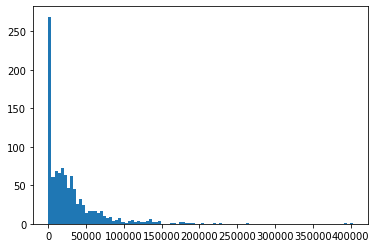

In [9]:
fc2_gradS = model.fc2.weightS.grad.data.cpu().view(-1).numpy()
print(len(fc2_gradS))
_ = plt.hist(fc2_gradS,100)

1024


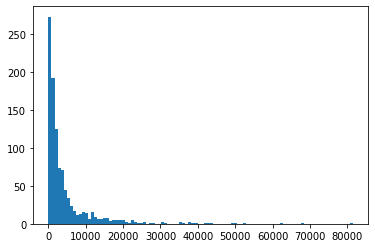

In [10]:
fc3_gradS = model.fc3.weightS.grad.data.cpu().view(-1).numpy()
print(len(fc3_gradS))
_ = plt.hist(fc3_gradS,100)

25088


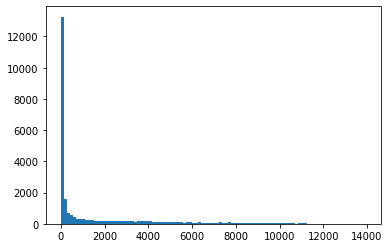

In [12]:
fc3_gradS = model.fc1.weightS.grad.data.cpu().view(-1).numpy()
print(len(fc3_gradS))
_ = plt.hist(fc3_gradS,100)